## Predicting Upgradability

Last updated: 20 July 2022 by Julia Suter

### Structure of Notebook<a id='top'></a>

[**Measuring and Predicting Upgradability**](#intro)

[**Loading and Preparing the Data**](#load_prep)
- [Loading the data](#load)
- [Preparing features](#prep)

[**Model for Predicting Upgradability**](#model)
- [Feature pipeline](#pipe)
- [Training and evaluation pipeline](#train_ev)
- [Evaluation](#evaluation)

[**Upgradability by Area**](#arera)
- [Aggregating the data on hex level](#aggr_hex)
- [Map for upgradability by hex](#map_hex)
- [Aggregating the data on local authority level](#aggr_la)
- [Map for upgradability by local authority](#map_la)



## Measuring and Predicting Upgradability<a id='intro'></a>

As one of our projects in A Sustainable Future at Nesta, we design a new retrofit loan together with the Development Bank Wales that will allow property owners in Wales to ugprade their home and make it more energy efficient (fewer carbon emissions). This gives home owners the opportunity to future-proof their homes, even if they could not pay for the upfront costs of retrofit measures all at once. 

Using data science and the Energy Performance Certificate (EPC) data, we can help identify areas that would be suitable for launching a pilot for such a loan. The ideal area would have many properties that can be retrofitted/upgraded and lie within a less-deprived area.

This codebase demonstrates a method for predicting upgradability of a property (and areas) based on EPC records. We incorporate the fact that some properties have several EPC records over time, which allows us to study which upgrades have been implemented in the past. 

While interested in the overall upgradability of a property, we also want to study the individual upgrade categories: roof, walls, floor, windows, lighting, main heat and hot water. 

We consider a property upgradable in a specific category, if a) we can observe an upgrade in that category between the earliest and most recent record, and/or if b) an upgrade in that category is recommended by the EPC recommendations. Since we do not have multiple records or recommendations for all properties, there are limitations to the data. Nonetheless, we have attempted to build a tool for measuring and predicting upgradability.

The purpose of this tool is to highlight areas with highest potential for upgrades and potentially 
identify most impactful combinations of retrofit measures. It will never be used to decide which property should get which upgrade (without further expert assessment) or who should/could apply for a retrofit loan. 


More information can be found in this [slide deck](https://docs.google.com/presentation/d/1lcK895k0re_TpbtdKXe3jmRwj-dXGvQBkNsTaKxL2cU/edit?usp=sharing).


<br>
<br> 
<div>
<img src="https://user-images.githubusercontent.com/42718928/179939383-0cab1163-dcb9-439d-a673-e98707d29188.png" width="1500"/>
</div>

## Loading and preparing the data<a id='load_prep'></a>
[[back to top]](#top)


### Loading the data<a id='load'></a>

When executed the very first time, the EPC data is loaded from S3 and saved in `/outputs/data/`. This takes about 5min. After that, the data will be loaded from the local directory (<30 secs).

In [24]:
%load_ext autoreload
%autoreload 2

import pandas as pd

from asf_core_data.utils.visualisation import kepler

from development_bank_wales import PROJECT_DIR, Path

from development_bank_wales.pipeline.feature_preparation import (
    recommendations,
    feature_engineering,
    data_aggregation,
)
from development_bank_wales.pipeline.predictive_model import (
    model_preparation,
    plotting,
    evaluation,
    training,
)

from keplergl import KeplerGl

import warnings

warnings.simplefilter(action="ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
output_path = PROJECT_DIR / "outputs/data/wales_epc_with_recs.csv"
fig_output_path = PROJECT_DIR / "outputs/figures/"

if not Path(output_path).is_file():

    print("Loading and preparing the data...")

    wales_df = recommendations.load_epc_certs_and_recs(
        data_path="S3", subset="Wales", n_samples=None, remove_duplicates=False
    )

    wales_df.to_csv(output_path, index=False)

    print("Done!")

else:

    print("Loading the data...")
    wales_df = pd.read_csv(output_path)
    print("Done!")

Loading the data...
Done!


### Preparing features<a id='prep'></a>
[[back to top]](#top)

We clean the description features, reduce the set to owner-occupied properties and retrieve information about upgrades and upgradability scores for the different categories.

In [26]:
wales_df = feature_engineering.get_upgrade_features(wales_df)
wales_df.head()

,LMK_KEY,ADDRESS1,ADDRESS2,POSTCODE,BUILDING_REFERENCE_NUMBER,CURRENT_ENERGY_RATING,POTENTIAL_ENERGY_RATING,CURRENT_ENERGY_EFFICIENCY,PROPERTY_TYPE,BUILT_FORM,...,MAINHEAT_ENERGY_EFF_NUM,MAINHEAT_EFF_DIFF,TOTAL_ENERGY_EFF_NUM,ROOF_UPGRADABILITY,WINDOWS_UPGRADABILITY,WALLS_UPGRADABILITY,FLOOR_UPGRADABILITY,LIGHTING_UPGRADABILITY,HOT_WATER_UPGRADABILITY,MAINHEAT_UPGRADABILITY
0,1753267654352019092420402198210261,Llais y Gwynt,Bodedern,LL65 4BU,2124486678,E,B,48,Bungalow,Detached,...,2.0,0.0,3.333333,False,False,True,True,True,True,False
1,814854529962012071718032980438172,"6, New Park Road",unknown,LL65 1PH,7818220078,D,B,62,House,Semi-Detached,...,4.0,0.0,3.000000,True,False,True,True,True,True,False
2,552884779002010101517252185009358,Bryn Siriol,unknown,LL67 0DS,5054670868,F,E,34,Bungalow,Detached,...,3.0,0.0,2.833333,False,False,True,False,True,True,True
3,204386690062009010717181396368921,"2, Minffordd Road",Caergeiliog,LL65 3NA,2986916568,D,C,64,House,End-Terrace,...,5.0,0.0,3.333333,False,False,False,False,False,False,False
4,207726359552009010816482101010358,"1, Nant y Felin",unknown,LL65 2TQ,3826916568,D,C,60,Bungalow,Detached,...,4.0,0.0,3.666667,True,False,False,False,False,False,False


## Model for predicting upgradability<a id='model'></a>
[[back to top]](#top)

For a given category, for example ROOF, we can train a model and predict the upgradability for unseen properties. 


### Feature pipeline<a id='pipe'></a>

The feature preparation pipeline `model_preparation.feature_prep_pipeline` perpares the features so they are ready for the machine learning model.
We clean the description features, reduce the set to owner-occupied properties and retrieve information about upgrades and upgradability scores for the different categories.

We pass the features through the preparation pipeline that handles the following:
- sample balancing
- feature selection (given specific label)
- feature encoding
- imputing
- scaling
- if needed: principal component analysis

### Training and evaluation pipeline<a id='train_ev'></a>


The training function `training.train_and_evaluate_model` trains and evaluates the model:
- split the data into training and test data
- fit the model
- make predictions
- evaluate the performance for baseline and test/train sets
- create a confusion matrix
- identify the most important features
- return upgradability scores/upgrade probabilities for all samples

**This will take a while because of the 5-fold cross-validation.**


### Evaluation<a id='evaluation'></a>

The logistic regression model performs very well when predicting ROOF_UPGRADABILITY, WALLS_UPGRADABILITY and FLOOR_UPGRADABILTIY with accuarcy scores of 84.47%, 94.85% and 90.51%, respectively, clearly outperforming the baseline. 

The features with strongest coefficients generally seem to fit for the respective prediction label, for example the most important features when predicting WALLS_UPGRADABILITY include 8 derived form the WALLS_DESCRIPTION feature. Properties with filled cavity and well insulated walls are less likely be suitable for (another) wall upgrade, while those with cavity and granite walls are more likely to benefit from futher retrofit measures.

The feature coefficients suggest that the model picks up suitable information from the feature set and bases its predictions on relevant features, introducing little noise.

Predicting ROOF_UPGRADABILITY with Logistic Regression
***************************************

# Training Samples: 391898
# Testing Samples: 130633
# Features: 131

Baseline: 
************
Accuracy:	60.43%
F1 score:	27.22%
Recall:		27.22%
Precision:	27.22%

Training Set:
************

5-fold Cross Validation
-------------------------

Accuracy:	84.43%
F1 Score:	69.01%
Recall:		63.79%
Precision:	75.17%

Test Set:
************

5-fold Cross Validation
-------------------------

Accuracy:	84.47%
F1 Score:	69.00%
Recall:		63.59%
Precision:	75.42%


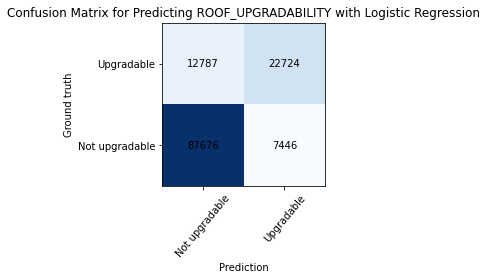

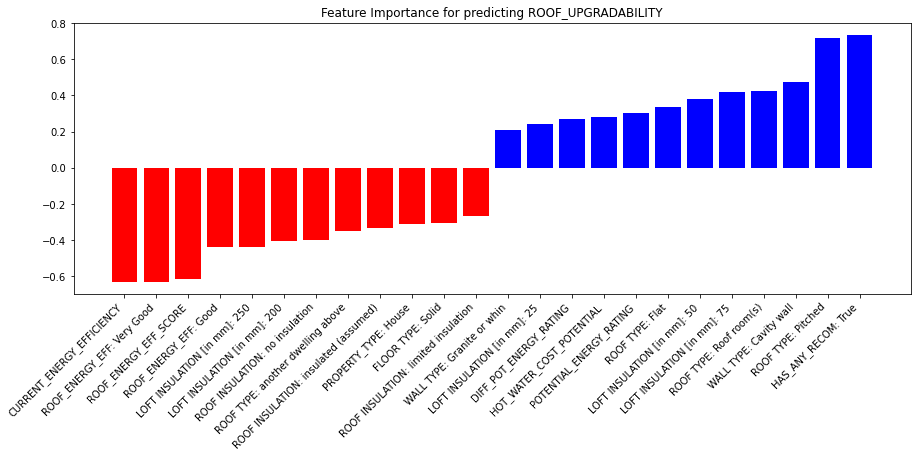

Predicting WALLS_UPGRADABILITY with Logistic Regression
***************************************

# Training Samples: 391898
# Testing Samples: 130633
# Features: 131

Baseline: 
************
Accuracy:	49.96%
F1 score:	49.69%
Recall:		49.69%
Precision:	49.69%

Training Set:
************

5-fold Cross Validation
-------------------------

Accuracy:	94.94%
F1 Score:	94.79%
Recall:		92.53%
Precision:	97.16%

Test Set:
************

5-fold Cross Validation
-------------------------

Accuracy:	94.85%
F1 Score:	94.70%
Recall:		92.47%
Precision:	97.03%


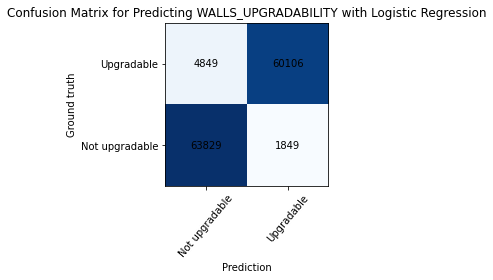

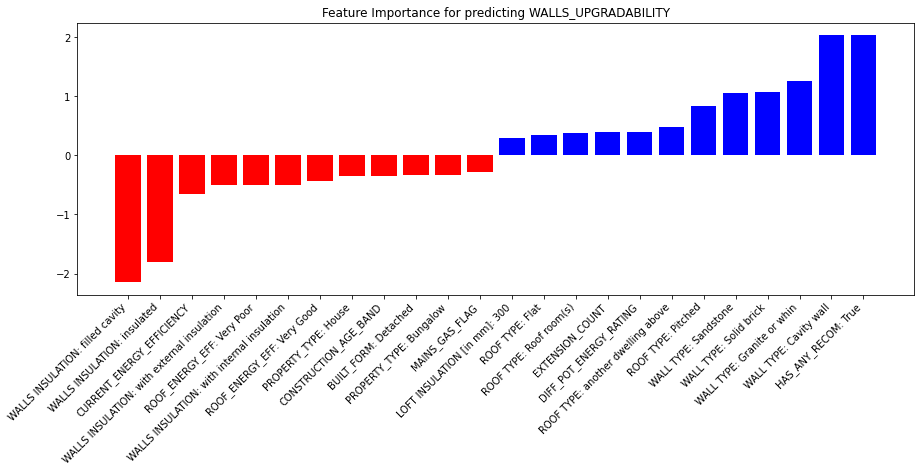

Predicting FLOOR_UPGRADABILITY with Logistic Regression
***************************************

# Training Samples: 391898
# Testing Samples: 130633
# Features: 131

Baseline: 
************
Accuracy:	50.21%
F1 score:	54.22%
Recall:		54.22%
Precision:	54.22%

Training Set:
************

5-fold Cross Validation
-------------------------

Accuracy:	90.73%
F1 Score:	91.72%
Recall:		94.38%
Precision:	89.21%

Test Set:
************

5-fold Cross Validation
-------------------------

Accuracy:	90.51%
F1 Score:	91.53%
Recall:		94.30%
Precision:	88.92%


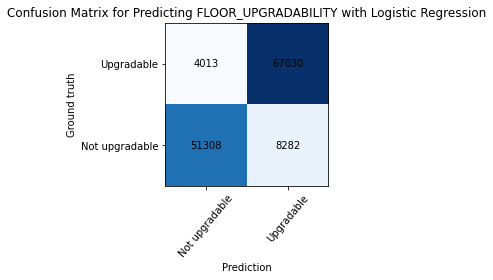

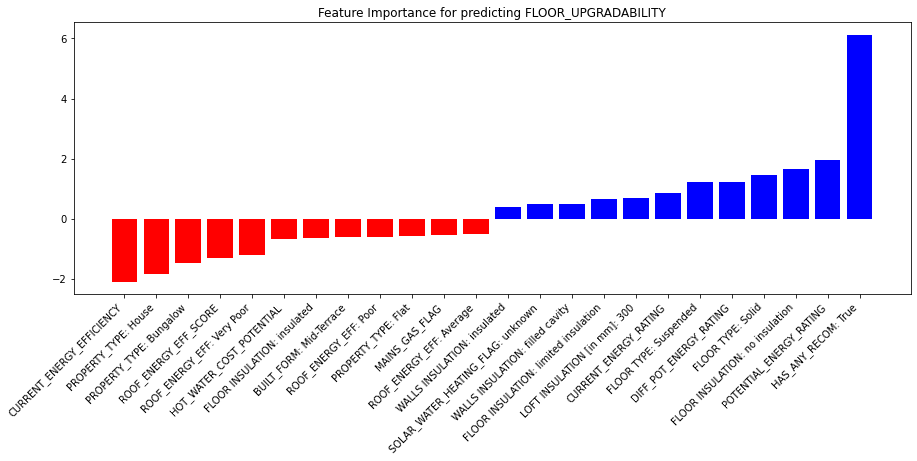

In [27]:
features_df = wales_df.copy()

label = "ROOF_UPGRADABILITY"
label_set = ["ROOF_UPGRADABILITY", "WALLS_UPGRADABILITY", "FLOOR_UPGRADABILITY"]

for label in label_set:

    processed_features, labels, feature_list = model_preparation.feature_prep_pipeline(
        wales_df, label
    )
    probas = training.train_and_evaluate_model(
        processed_features, labels, "Logistic Regression", label, feature_list
    )

    features_df["proba {}".format(label)] = probas

## Upgradability by Area<a id='area'></a>
[[back to top]](#top)

The overall upgradability for a property is computed by weighting the individual upgradabilities  for the different categories (roof, walls, floor). In this case, we give most weight to wall upgradability and lower weight to floor upgradability, since the floor is less likely to be a part of retrofit measures given the disruptive process.

```
ROOF_UPGRADABILITY:  0.35
WALLS_UPGRADABILITY: 0.5
FLOOR_UPGRADABILITY: 0.15
```

After predicting the individual and total upgradabilities for each property, we can compute average upgradability for areas. We aggregate the data on hex_id level (area of ~36 km2) or local authority level (to be improved with proper shapefiles). Other geographical levels would be possible as well, but are not yet implemented.

### Aggregating the data on hex level<a id='aggr_hex'></a>

In [28]:
features_df = data_aggregation.get_supplementary_data(features_df, data_path="S3")
data_per_group = data_aggregation.get_mean_per_group(features_df, label_set)
data_per_group.head()

,hex_id,# Properties,IMD Decile (mean),proba ROOF_UPGRADABILITY,proba WALLS_UPGRADABILITY,proba FLOOR_UPGRADABILITY,weighted proba
0,0,157,4.0,0.179244,0.544512,0.159909,0.119659
1,861829867ffffff,11,5.0,0.597143,0.756923,0.764872,0.234064
2,86182992fffffff,340,7.0,0.298572,0.529180,0.575576,0.151809
3,861829947ffffff,3,5.0,0.213538,0.658637,0.658299,0.167601
4,86182994fffffff,199,5.0,0.400631,0.522866,0.597194,0.163744


### Map for upgradability by hex<a id='hex_map'></a>
[[back to top]](#top)

We create a Kepler map showing the average upgradability scores for different categories and the weighted upgradability score across Wales.
By switching between layers, you can investigate the weighted upgradability, roof upgradability, walls upgradability, number of (EPC) properties, and the Index of Multiple Deprivation Decile. 

A map like this could help identifying areas suitable for launching a pilot for a retrofit loan. The weighted upgradability can be fine-tuned depending on the loan's focus and specifications.

In [29]:
config = kepler.get_config("upgradability.txt", data_path=PROJECT_DIR)

upgradability_map = KeplerGl(height=500, config=config)

upgradability_map.add_data(
    data=data_per_group[
        [
            "proba ROOF_UPGRADABILITY",
            "hex_id",
        ]
    ],
    name="Roof",
)

upgradability_map.add_data(
    data=data_per_group[
        [
            "proba WALLS_UPGRADABILITY",
            "hex_id",
        ]
    ],
    name="Walls",
)

upgradability_map.add_data(
    data=data_per_group[
        [
            "weighted proba",
            "hex_id",
        ]
    ],
    name="Weighted combo upgradability",
)


upgradability_map.add_data(
    data=data_per_group[["hex_id", "IMD Decile (mean)"]], name="IMD"
)
upgradability_map.add_data(
    data=data_per_group[["hex_id", "# Properties"]], name="Density"
)


upgradability_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '3kjbyoh', 'type': …

In [30]:
kepler.save_config(upgradability_map, "upgradability.txt", data_path=PROJECT_DIR)
kepler.save_map(upgradability_map, "Upgradability.html", data_path=PROJECT_DIR)

Map saved to /Users/juliasuter/Documents/repositories/development_bank_wales/outputs/figures/kepler/maps/Upgradability.html!


### Aggregating the data on local authority level<a id='aggr_la'></a>
[[back to top]](#top)


In [31]:
data_per_group = data_aggregation.get_mean_per_group(
    features_df, label_set, agglo_f="LOCAL_AUTHORITY_LABEL"
)

Index(['hex_id', 'LOCAL_AUTHORITY_LABEL'], dtype='object', name='LOCAL_AUTHORITY_LABEL')
Index(['LOCAL_AUTHORITY_LABEL', '# Properties', 'IMD Decile (mean)',
       'proba ROOF_UPGRADABILITY', 'proba WALLS_UPGRADABILITY',
       'proba FLOOR_UPGRADABILITY', 'weighted proba'],
      dtype='object')


### Map for upgradability by local authority<a id='map_la'></a>
[[back to top]](#top)


By switching between layers, you can investigate the weighted upgradability, roof upgradability, walls upgradability, number of (EPC) properties, and the Index of Multiple Deprivation Decile. 

In [32]:
config = kepler.get_config("LA_upgradability.txt", data_path=PROJECT_DIR)

upgradability_map = KeplerGl(height=500, config=config)

upgradability_map.add_data(
    data=data_per_group[
        ["proba ROOF_UPGRADABILITY", "hex_id", "LOCAL_AUTHORITY_LABEL"]
    ],
    name="Roof",
)

upgradability_map.add_data(
    data=data_per_group[
        ["proba WALLS_UPGRADABILITY", "hex_id", "LOCAL_AUTHORITY_LABEL"]
    ],
    name="Walls",
)

upgradability_map.add_data(
    data=data_per_group[["weighted proba", "hex_id", "LOCAL_AUTHORITY_LABEL"]],
    name="Weighted combo upgradability",
)


upgradability_map.add_data(
    data=data_per_group[["hex_id", "IMD Decile (mean)", "LOCAL_AUTHORITY_LABEL"]],
    name="IMD",
)
upgradability_map.add_data(
    data=data_per_group[["hex_id", "# Properties", "LOCAL_AUTHORITY_LABEL"]],
    name="Density",
)


upgradability_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '3kjbyoh', 'type': …

In [33]:
kepler.save_config(upgradability_map, "LA_upgradability.txt", data_path=PROJECT_DIR)
kepler.save_map(upgradability_map, "LA_Upgradability.html", data_path=PROJECT_DIR)

Map saved to /Users/juliasuter/Documents/repositories/development_bank_wales/outputs/figures/kepler/maps/LA_Upgradability.html!
